In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline

### Data Exploration and Cleaning

In [2]:
# load and examine the data
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [65]:
users_df = pd.read_csv('takehome_users.csv', encoding='cp1252')
print(users_df.shape)
users_df.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [66]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [67]:
# lets examine the user data to see who is actually using the application
print('There are {} users who have ever used the application.'\
          .format(len(list(user_engagement_df['user_id'].unique()))))
print('There are {} signed up for the application.'\
          .format(len(list(users_df['object_id'].unique()))))

print('There is a discrepancy of {} users.'\
          .format(int(len(list(users_df['object_id'].unique()))) 
                  - int(len(list(user_engagement_df['user_id'].unique())))))

# how many people never signed in?
print('There are ', len(users_df[users_df['last_session_creation_time'].isnull()]), 'inactive users.')

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a discrepancy of 3177 users.
There are  3177 inactive users.


So, at this point we have two data sets. The first, we can use to determine if a user is "adopted" the app. Then with the second data set we can use these determined ID's to then produce and evaluate a predictive model. As part of this process we will have to deal with any missing, duplicate, and/or irrelevant data points.

As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

In [68]:
# How much missing data do we have e.g. if we drop it how much info is gone?
print(users_df['last_session_creation_time'].isnull().value_counts())
print(users_df['invited_by_user_id'].isnull().value_counts())

False    8823
True     3177
Name: last_session_creation_time, dtype: int64
False    6417
True     5583
Name: invited_by_user_id, dtype: int64


In [69]:
#Convert the time columns to datetime
users_df.creation_time = pd.to_datetime(users_df.creation_time)

#Convert the columns to boolean
users_df.opted_in_to_mailing_list = users_df.opted_in_to_mailing_list.astype('bool')
users_df.enabled_for_marketing_drip = users_df.enabled_for_marketing_drip.astype('bool')

#Convert to categorical
users_df.creation_source = users_df.creation_source.astype('category')

#Re-name user id appropriately
users_df['user_id'] = users_df.object_id
users_df.drop('object_id', axis=1, inplace=True)

#Keep only info on if user was invited
users_df['invited'] = np.where(users_df['invited_by_user_id'].isnull(), True, False)
users_df.drop('invited_by_user_id', axis=1, inplace=True)

#We don't need personal information
users_df.drop(['name', 'email'], axis=1, inplace=True)

In [71]:
#Convert time column to datetime
user_engagement_df.time_stamp = pd.to_datetime(user_engagement_df.time_stamp)


The heart of this problem is to correctly determine which users can be classified as adopted users. We can do this by grouping the engagement data by user. Then we can loop over the sorted time stamp data for a single user. Here we can simply construct a 7 day window from a given time stamp and demand the next two time stamps be within that window. Users who do not fill this criteria are not adopted users.

In [73]:
# time to add in the adopted user feature so that we can categorize the data
seven_days = datetime.timedelta(7)
adopted_dict = {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user = False
    temp = user_engagement_df[user_engagement_df['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        this_time = temp.get_value(row[0], 'time_stamp')
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [74]:
# what percentage of the users are sticking around?
count_df = pd.DataFrame.from_dict(Counter(list(adopted_dict.values())), orient='index').reset_index()

print('We have analyzed logs for', len(adopted_dict), 'unique users.')
print(round((count_df.loc[1][1]/(count_df.loc[1][1]+count_df.loc[0][1])*100),2) ,'of users are adopted-users.')

We have analyzed logs for 8823 unique users.
18.77 of users are adopted-users.


In [75]:
# Create adopted target variable and display dataset again
users_df['adopted'] = False
users_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,user_id,invited,adopted
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,True,False,11,1,False,False
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,False,False,1,2,False,False
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,False,False,94,3,False,False
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,False,False,1,4,False,False
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,False,False,193,5,False,False


In [76]:
# Replace adopted target class with correct flags
for row in (users_df[np.logical_not(users_df['last_session_creation_time'].isnull())]).itertuples():
    adopted_value = adopted_dict[users_df.get_value(row[0], 'user_id')]
    users_df.set_value(row[0], 'adopted', adopted_value)
    
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(len(users_df[users_df['adopted'] == True])/len(users_df)*100))

C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


13.80% of all users who have signed up for the application are considered 'adopted users'.


In [77]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
False    9006
True     2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
False    10208
True      1792
Name: enabled_for_marketing_drip, dtype: int64



In [78]:
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['last_session_creation_time'].median())


users_df['creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
# day of the week account created
users_df['day_created'] = users_df['creation_time'].apply(lambda x: x.dayofweek)
# hour of the day account created
users_df['hour_created'] = users_df['creation_time'].apply(lambda x: x.hour)
# drop the original column
users_df.drop('creation_time', axis=1, inplace=True)

In [72]:
adopted_dict = {x:False for x in range(1, len(users_df)+1)}
count = 0
for group in user_engagement_df.groupby('user_id'):
    
    #Define useful vars
    user_id = group[0]
    user_times = group[1]['time_stamp'].sort_values().reset_index(drop=True)
    num_engage = len(user_times)
    
    #If there are less than 3 engagements, they do not qualify
    if num_engage < 3:
        continue
     
    #Iterate over the engagement timestampe
    for i, stamp in enumerate(user_times):
        
        #Ensure we don't go off the end of the array of timestamps
        if i == num_engage-2:
            break
            
        #Define useful timestamp vars    
        start = stamp
        end = start + pd.Timedelta('7D')
        next1 = user_times[i+1]
        next2 = user_times[i+2]
        
        #Are the next two timestamps within a week?
        if (next1 < end) & (next2 < end):
            adopted_dict[user_id] = True
            count+=1
            break    
            
print('There are {} adopted users.'.format(count))

There are 1602 adopted users.



**Note:** that of the 12,000 users, only 1,602 are adopted. This means the target variable is highly imbalanced. However, again we are not as concerned with a great predictive model as we are about the underlying variables and their relationships with the target variable.


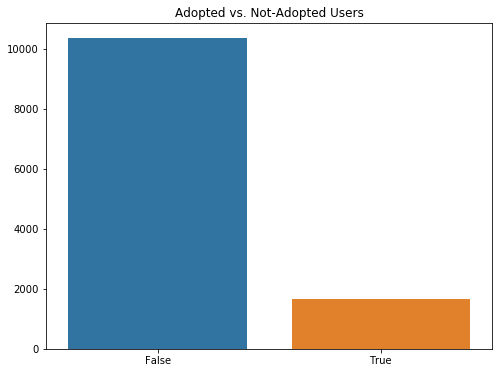

In [82]:
# Take another look at the distribution of the target class
plt.figure(figsize=(8, 6))
sns.barplot(x = list(users_df['adopted'].value_counts().index), y = users_df['adopted'].value_counts())
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users')
plt.show()

***

In [87]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_df, columns = ['creation_source'])

In [88]:
X = df_encoded.drop('adopted', axis=1)
y = df_encoded['adopted']

In [89]:
# Split into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,
                                                    random_state=2007, stratify=users_df['adopted'])

In [92]:
#SMOTE oversampling to balance out the classes

from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))

[(False, 7241), (True, 7242)]


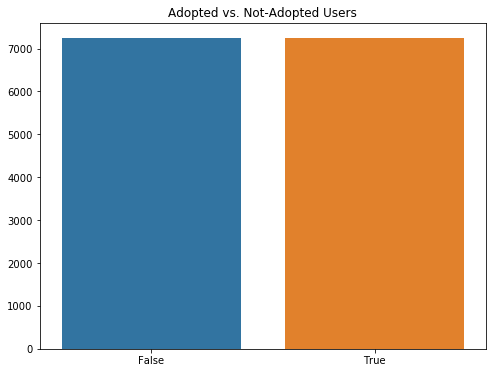

In [95]:
# Take a look at the distribution of the enhanced target class
plt.figure(figsize=(8, 6))
sns.countplot(y_resampled)
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users')
plt.show()

### Building and Evaluating Model

In [97]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
# from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [102]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('GB', GradientBoostingClassifier()))

In [103]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.906111
1  SVC  0.861944
2   LR  0.861944
3   DT  0.869722
4  GNB  0.861944
5   RF  0.914722
6   GB  0.913889


In [105]:
names = []
scores = []
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.910750
1  SVC  0.862000
2   LR  0.862000
3   DT  0.863250
4  GNB  0.862000
5   RF  0.913667
6   GB  0.916583


In [106]:
clf = GradientBoostingClassifier(verbose=False)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

Train Score: 0.929
Test Score: 0.914


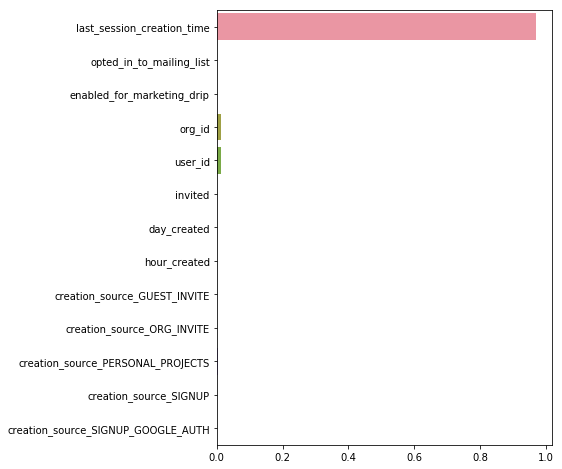

In [110]:
features = pd.Series(clf.feature_importances_, index=X.columns)

plt.figure(figsize=(6,8))
sns.barplot(y=X.columns, x=clf.feature_importances_)
plt.show()

In [108]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.968676
user_id,0.013751
org_id,0.011540
creation_source_PERSONAL_PROJECTS,0.002323
creation_source_GUEST_INVITE,0.001169
enabled_for_marketing_drip,0.000958
creation_source_ORG_INVITE,0.000456
invited,0.000401
creation_source_SIGNUP,0.000362
opted_in_to_mailing_list,0.000313


**Conclusions:**


The feature rankings in the table above show 6 important features that can predict the adopted users best. In essence, it really is only three features, as the two datetime features were converted into three different features. So the answer to the prompt is: the creation_time and last_session_creation_time features alongside the org_id are the most important factors which can predict user adoption, according to the given defintion.

With approximatly 81% of the userbase not considered non adoptive users, we have an obvious area for improvment in user engagment. This is also exemplified by the fact that we have several thousand users who, after creating an account, never engaged with the system (loged in). From the feature importances the last log in time was the most highly correlated with a positive prediction, which is not surprising. However, I am not certain how useful the is as a real world predictor as those who have logged in more recently are more likely to be in the engaged crowed, and thus this dilutes its usefulness as a predictor of whether or not a novel user will become an adopted user. My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new commonfeatures to add to the model that may increase its validity